<a href="https://colab.research.google.com/github/kevinmfreire/sentiment-analysis/blob/main/tweet_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Dataset Analysis

## First let's download datasets from google drive to google collab.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp -r /gdrive/MyDrive/SharpestMinds/datasets/ /content/

##Now that we have our dataset, we have three objectives: 
* Understand the dataset and clean it up
* Build a classification model to predict the twitter sentiment
* Compare the evalutation metrics of a few classification algorithms

We first want to import our libraries

In [ ]:
!pip install scikit-plot

In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
import math

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV,RepeatedStratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, precision_score, recall_score
from scikitplot.metrics import plot_roc_curve as auc_roc

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Dwnloading NLTK packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Exploration

In [ ]:
# Load dataset then check columns and values
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
tweet_df = pd.read_csv("./datasets/sentiment140/tweets.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
tweet_df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


* Let's check additional information on dataset

In [ ]:
tweet_df.describe(include='O')

,date,flag,user,text
count,1600000,1600000,1600000,1600000
unique,774363,1,659775,1581466
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1600000,549,210


* We do not need the date, ids, flag or user, I will drop those columns and keepy sentiment and text.

In [ ]:
tweet_df.drop(['ids','date', 'flag', 'user'], axis=1, inplace=True)
tweet_df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


* The Kaggle Sentiment140 dataset has values 0=negative and 4=positive.
* I will replace all values with -1=negative and 1=positive.

In [ ]:
to_sentiment = {0: "negative", 4: "positive"}
def label_decoder(label):
    return to_sentiment[label]

tweet_df.sentiment = tweet_df.sentiment.apply(lambda x: label_decoder(x))
tweet_df.head()

,sentiment,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


* I create a target value to select the column 'sentiment'
* Then I copy the dataset as original_df

In [ ]:
target = 'sentiment'
original_df = tweet_df.copy(deep=True)

In [ ]:
print('\n\033[1mData Dimension:\033[0m Dataset consists of {} columns & {} records.'.format(tweet_df.shape[1], tweet_df.shape[0]))


Data Dimension: Dataset consists of 2 columns & 1600000 records.


In [ ]:
# Let's check the dtypes of all columns

tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  object
 1   text       1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


In [ ]:
# Checking the stats of all the columns

tweet_df.describe()

,sentiment,text
count,1600000,1600000
unique,2,1581466
top,negative,isPlayer Has Died! Sorry
freq,800000,210


# Data Processing

In [ ]:
# Check for empty elements

tweet_df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [ ]:
# Remove any missing values
# rom the above cell there are no missing values so we do not run this cell

# tweet_df = tweet_df.dropna(inplace=True)
# original_df = tweet_df.copy(deep=True)

In [ ]:
tweet_df[tweet_df.duplicated()]

,sentiment,text
1940,negative,and so the editing of 3000 wedding shots begins
2149,negative,"im lonely keep me company! 22 female, california"
3743,negative,I'm not liking that new iTunes Pricing at all....
3746,negative,"cant eat, drink or breath properly thanks to t..."
4163,negative,has a cold
...,...,...
1599450,positive,Good morning!
1599501,positive,getting used to twitter
1599531,positive,@KhloeKardashian Definitely my Mom. And Angeli...
1599678,positive,goodmorning


In [ ]:
# Let's remove duplicated rows (if any)

counter = 0
r, c = original_df.shape

tweet_df_dedup = tweet_df.drop_duplicates()
tweet_df_dedup.reset_index(drop=True, inplace=True)

if tweet_df_dedup.shape==(r,c):
  print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
  print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-tweet_df_dedup.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 16309


In [ ]:
tweet_df_dedup.head()

,sentiment,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


With computational complexity I will reduce the data by a scale of 4 so the text pre-processing will not take too long and once we have a baseline model I will then train the model with the entire dataset.

In [ ]:
def split_data(data, scale):
  neg_df = data[data['sentiment']=='negative']
  pos_df = data[data['sentiment']=='positive']
  neg_df = neg_df[0:(len(neg_df)//scale)]
  pos_df = pos_df[0:(len(pos_df)//scale)]
  new_df = [neg_df, pos_df]
  new_df = pd.concat(new_df)
  return new_df

new_df_split = split_data(tweet_df_dedup, 4)
new_df_split.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395922 entries, 0 to 988560
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  395922 non-null  object
 1   text       395922 non-null  object
dtypes: object(2)
memory usage: 9.1+ MB


## Let's do some basic text processing such as:
* Convert to lower case
* Tokenisation
* Remove puntuation
* Remove stop words
* Stemming
* Lemmatization

In [ ]:
# Cleaning the text

# tweet_df_clean = tweet_df_dedup.copy()
tweet_df_clean = new_df_split.copy()

def preprocessor(text):
  text = re.sub('[^a-zA-Z]',' ', text)    # remove punctuation
  text = text.lower()                     # convert to lowercase
  text = text.strip()                     # remove leading and tailing whitespaces
  # Stemming
  text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
  text = ' '.join([word for word in text.split() if word.isalnum()])  
  text = ' '.join([WordNetLemmatizer().lemmatize(word,pos='v') for word in text.split()]) 
  text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
  return text

In [ ]:
# tweet_df_clean['text'] = tweet_df_dedup['text'].apply(preprocessor)
tweet_df_clean['text'] = new_df_split['text'].apply(preprocessor)
tweet_df_clean.head()

,sentiment,text
0,negative,switchfoot http twitpic com zl awww bummer sho...
1,negative,upset update facebook texting might cry result...
2,negative,kenichan dive many time ball manage save rest ...
3,negative,whole body feel itchy like fire
4,negative,nationwideclass behave mad see


**Inference:** The text is now clean from the removal of all punctuations, stop words and stemming.

* We next want to tokenize our dataset using Porter Stemmer

In [ ]:
porter = PorterStemmer()

def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

Let's extract features using TF-IDF

In [ ]:
tf_idf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer_porter, use_idf=True, norm='l2', smooth_idf=True)
label=tweet_df_clean[target].values
features=tf_idf.fit_transform(tweet_df_clean.text)

Let's look at the labels

In [ ]:
label

array(['negative', 'negative', 'negative', ..., 'positive', 'positive',
       'positive'], dtype=object)

Now let's look at the features

In [ ]:
features

<395922x198422 sparse matrix of type '<class 'numpy.float64'>'
	with 2977585 stored elements in Compressed Sparse Row format>

## Exploratory Data Analysis (EDA)

Text(0.5, 1.0, 'Sentiment Data Distribution')

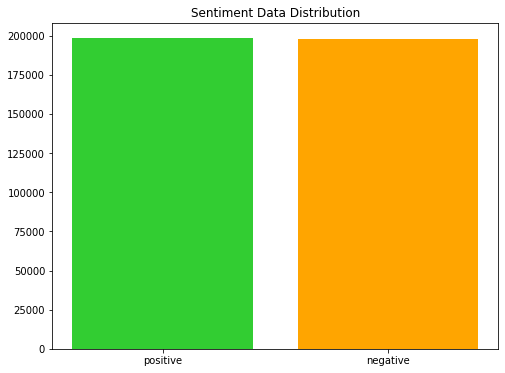

In [ ]:
# Let'sanalyze the distribution oof the target values

# print('\033[1mTarget Variable Distribution'.center(55))
# plt.bar(tweet_df_clean[target].value_counts().index,tweet_df_clean[target].value_counts())
# plt.show()

val_count = tweet_df_clean.sentiment.value_counts()

plt.figure(figsize=(8,6))
plt.bar(val_count.index, val_count.values, color=['limegreen','orange'])
plt.title("Sentiment Data Distribution")

Both the Negative and Positive values seem to be about the same.

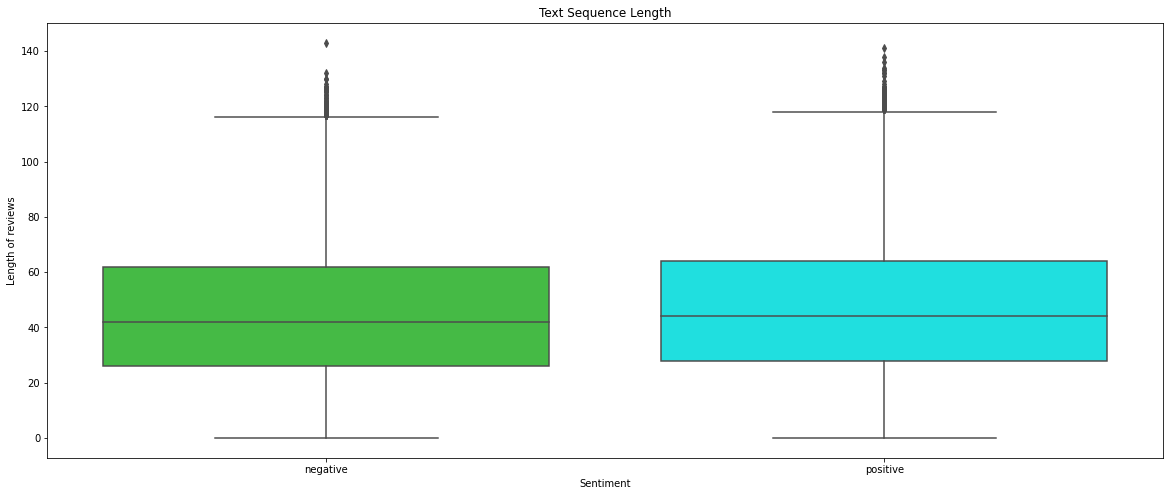

In [ ]:
# Visualizing the average text sequence length

tweet_df_rl = tweet_df_clean.copy()
tweet_df_rl['review_length'] = 0

tweet_df_rl['review_length'] = tweet_df_rl['text'].apply(lambda x:len(x))

plt.figure(figsize=[20,8])
sns.boxplot(x=label, y='review_length', data=tweet_df_rl, palette=['limegreen','cyan'])
plt.title('Text Sequence Length')
plt.xlabel("Sentiment")
plt.ylabel("Length of reviews")
plt.show()

**The sequence length for reviews on an average are almost similar for both positive and negative tweets**

* Let's compare with the original tweet dataframe we save earlier

In [ ]:
original_df = new_df_split.copy()
pos_df = original_df[original_df[target]=='positive']['text']
neg_df = original_df[original_df[target]=='negative']['text']

In [ ]:
def freq_text(text_df):
  combi_text=""
  for x in text_df.values:
    combi_text+=' '.join(x.split())
  combi_text = [x for x in combi_text.split() if len(x) >3 and x not in stopwords.words('english')]
  return combi_text

In [ ]:
def freq_df(text_count_df, senti):
  fredis=nltk.FreqDist(text_count_df)
  fredis_df = pd.DataFrame({senti: list(fredis.keys()), 'Count': list(fredis.values())})
  fredis_df = fredis_df.sort_values(by='Count', ascending=False)
  return fredis_df

In [ ]:
def plot_freq_dis(text_count_df,senti):
  sns.barplot(data=text_count_df[:10], x=senti, y='Count')

In [ ]:
pos_df.shape

(198376,)

In [ ]:
pos_df = pos_df.apply(preprocessor)

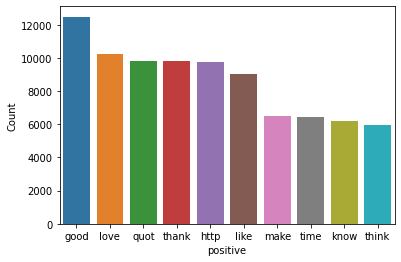

In [ ]:
senti = 'positive'
pos_text = freq_text(pos_df)
pos_freq_df = freq_df(pos_text,senti)
plot_freq_dis(pos_freq_df,senti)

In [ ]:
neg_df.shape

(197546,)

In [ ]:
neg_df = neg_df.apply(preprocessor)

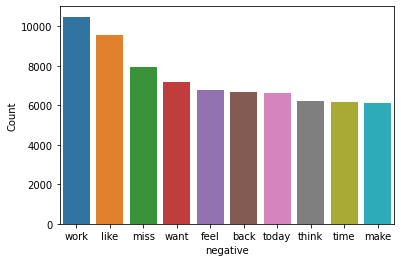

In [ ]:
senti='negative'
neg_text = freq_text(neg_df)
neg_freq_df = freq_df(neg_text, senti)
plot_freq_dis(neg_freq_df, senti)

In [ ]:
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

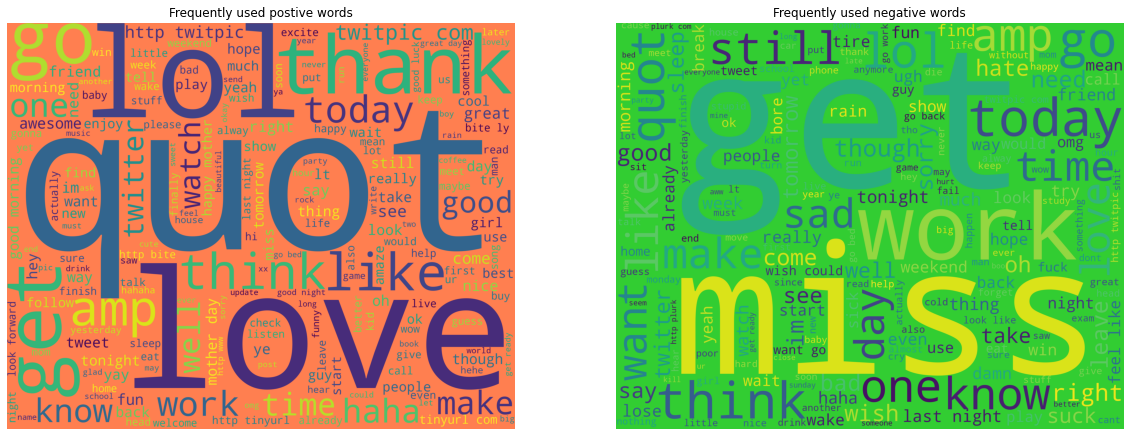

In [ ]:
plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(pos_df,'coral','Frequently used postive words')
plt.subplot(1,2,2)
wordcloud_draw(neg_df, 'limegreen','Frequently used negative words')
plt.show()

# Predictive Modeling

Let's begin a simple training

In [ ]:
#  Assigning labels to target variable

label_mapping = {'negative':0, 'positive':1}
tweet_df_clean['sentiment'] = tweet_df_clean['sentiment'].map(label_mapping)

In [ ]:
# Split data into training and testing sets

X = features
y = pd.Series(label).map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Original set  ---> ','feature size: ',X.shape,'label size',len(y))
print('Training set  ---> ','feature size: ',X_train.shape,'label size',len(y_train))
print('Test set  --->  ','feature size: ',X_test.shape,'label size',len(y_test))

Original set  --->  feature size:  (395922, 198422) label size 395922
Training set  --->  feature size:  (316737, 198422) label size 316737
Test set  --->   feature size:  (79185, 198422) label size 79185


In [ ]:
# Let's create a table to store the results of various models

result_df = pd.DataFrame(columns=['Models','Accuracy','Precision','Recall','F1-score','AUC-ROC score'])
result_df['Models']=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naive Bayes Classifier (NB)']
result_df.fillna(0.0,inplace=True)
result_df.set_index('Models',inplace=True)
result_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Models,,,,,
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naive Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [ ]:
result_df.loc['Logistic Regression (LR)','Accuracy']

0.0

In [ ]:
# Classification Summary Function

def classification_summary(pred, pred_prob, model):
  result_df.loc[model,'Accuracy'] = round(accuracy_score(y_test,pred),3)*100
  result_df.loc[model,'Precision'] = round(precision_score(y_test,pred,average='weighted'),3)*100
  result_df.loc[model,'Recall'] = round(recall_score(y_test,pred,average='weighted'),3)*100
  result_df.loc[model,'F1-score'] = round(f1_score(y_test,pred,average='weighted'),3)*100
  result_df.loc[model,'AUC-ROC score'] = round(roc_auc_score(y_test,pred,multi_class='ovr'),3)*100

  print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*25,model,'-'*25,'>'*3))
  print('Accuracy = {}%'.format(round(accuracy_score(y_test,pred),3)*100))
  print('F1 Score = {}%'.format(round(f1_score(y_test,pred,average='weighted'),3)*100))
  print('Precision Score = {}%'.format(round(precision_score(y_test,pred,average='weighted'),3)*100))
  print('Recall Score = {}%'.format(round(recall_score(y_test,pred,average='weighted'),3)*100))

  print('\n \033[1mConfusion Matrix:\033[0m\n',confusion_matrix(y_test,pred))
  print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test,pred))

  auc_roc(y_test,pred_prob,curves=['each_class'])
  plt.show()

In [ ]:
# Visualizing Function

def auc_roc_plot(y_test,pred):
  reg = [0 for _ in range(len(y_test))]
  ref_auc = roc_auc_score(y_test,ref)
  lr_auc = roc_auc_score(y_test, pred)

  ns_fpr, ns_tpr, _ = roc_curve(y_test,ref)
  lr_fpr, lr_tpr, _ = roc_curve(y_test,pred)

  plt.plot(ns_fpr, ns_tpr, linestyle='=')
  plt.plot(lr_fpr, lr_tpr, marker='*', label='AUC = {}'.format(round(roc_auc_score(y_test,pred)*100,2)))
  plt.xlabel('Flase Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

## 1. Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


<<<------------------------- Evaluating Logistic Regression (LR) ------------------------->>>

Accuracy = 76.7%
F1 Score = 76.7%
Precision Score = 76.8%
Recall Score = 76.7%

 Confusion Matrix:
 [[29424 10337]
 [ 8078 31346]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     39761
           1       0.75      0.80      0.77     39424

    accuracy                           0.77     79185
   macro avg       0.77      0.77      0.77     79185
weighted avg       0.77      0.77      0.77     79185



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


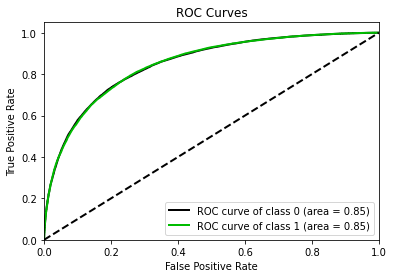

In [ ]:
# Building Logistic Regression Classifier

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
pred = log_reg_model.predict(X_test)
pred_prob = log_reg_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Logistic Regression (LR)')

## 2. Random Tree Classifier

<<<------------------------- Evaluating Decision Tree Classifier (DT) ------------------------->>>

Accuracy = 69.69999999999999%
F1 Score = 69.69999999999999%
Precision Score = 69.69999999999999%
Recall Score = 69.69999999999999%

 Confusion Matrix:
 [[27444 12317]
 [11659 27765]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.70     39761
           1       0.69      0.70      0.70     39424

    accuracy                           0.70     79185
   macro avg       0.70      0.70      0.70     79185
weighted avg       0.70      0.70      0.70     79185



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


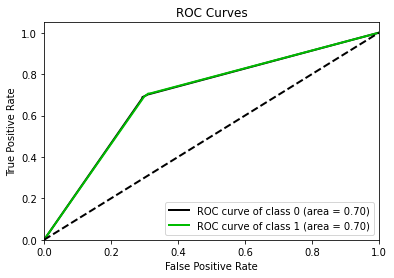

In [ ]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)
pred = DT_model.predict(X_test)
pred_prob = DT_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Decision Tree Classifier (DT)')

## 3. Random Forest Classifier:

<<<------------------------- Evaluating Random Forrest Classifier (RF) ------------------------->>>

Accuracy = 75.9%
F1 Score = 75.9%
Precision Score = 75.9%
Recall Score = 75.9%

 Confusion Matrix:
 [[29593 10168]
 [ 8909 30515]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76     39761
           1       0.75      0.77      0.76     39424

    accuracy                           0.76     79185
   macro avg       0.76      0.76      0.76     79185
weighted avg       0.76      0.76      0.76     79185



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


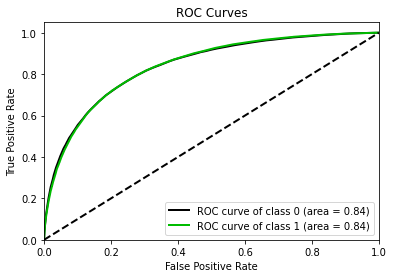

In [46]:
# Building Forrest Classifier

RF_model = RandomForestClassifier()
RF_model.fit(X_train,y_train)
pred = RF_model.predict(X_test)
pred_prob = RF_model.predict_proba(X_test)
classification_summary(pred, pred_prob, 'Random Forrest Classifier (RF)')

## 4. Naive Bayes Classifier

<<<------------------------- Evaluating Naive Bayes Classifier (NB ------------------------->>>

Accuracy = 75.4%
F1 Score = 75.4%
Precision Score = 75.5%
Recall Score = 75.4%

 Confusion Matrix:
 [[31307  8454]
 [10987 28437]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76     39761
           1       0.77      0.72      0.75     39424

    accuracy                           0.75     79185
   macro avg       0.76      0.75      0.75     79185
weighted avg       0.76      0.75      0.75     79185



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


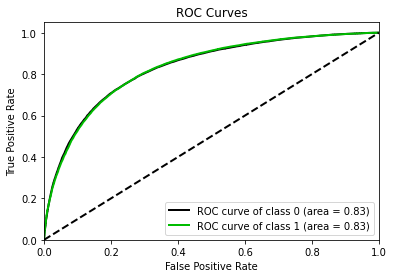

In [47]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB_model.fit(X_train,y_train)
pred = NB_model.predict(X_test)
pred_prob = NB_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Naive Bayes Classifier (NB')

## Comparing all the models

In [48]:
# Plotting Confusion-Matrix of all predictive Models

labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_prec = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
    for j in range(ncols):
      c = cm[i,j]
      p = cm_prec[i,j]
      if i==j:
        s = cm_sum[i]
        annot[i,j] = '%.1f%%\n%d/%d' % (p,c,s)
      elif c==0:
        annot[i,j] = ''
      else:
        annot[i,j] = '%.1f%%\n%d' % (p,c)
  cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
  cm.columns=labels
  cm.index=labels
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  sns.heatmap(cm, annot=annot, fmt='')

In [52]:
def conf_mat_plot(all_models):
  plt.figure(figsize=[20,3*math.ceil(1+len([all_models])/4)])

  for i in range(len(all_models)):
    if len(labels)<=4:
      plt.subplot(1,4,i+1)
    else:
      plt.subplot(math.ceil(len(all_models)/2),2,i+1)
    pred = all_models[i].predict(X_test)
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.0f')
    plt.title(result_df.index[i])
    plt.yticks([0,1], labels=['Actual Negative','Actual Positive'], rotation=45)
  plt.tight_layout()
  plt.show()

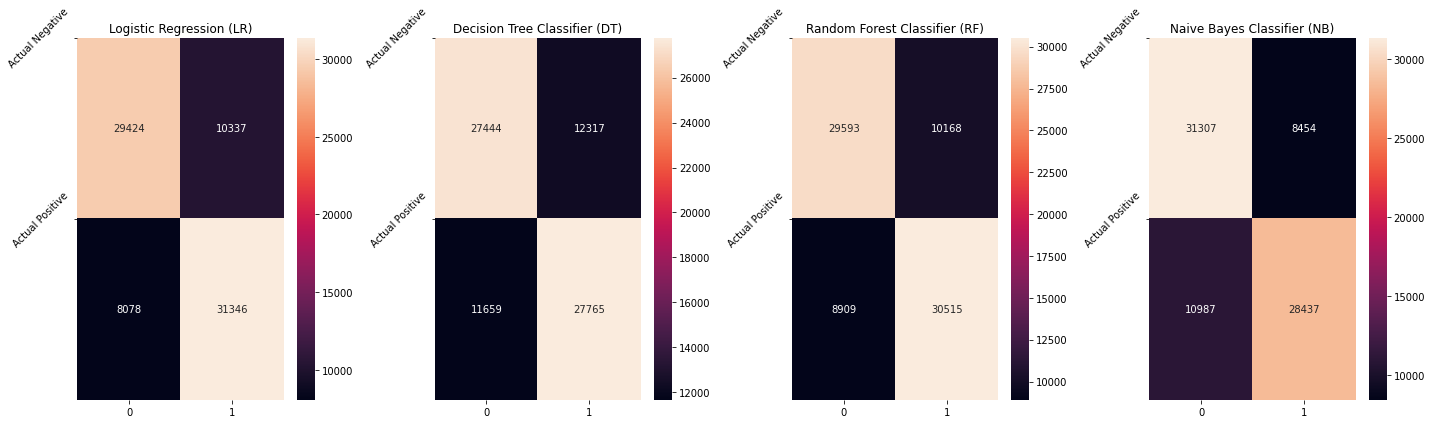

In [53]:
conf_mat_plot([log_reg_model, DT_model, RF_model, NB_model])

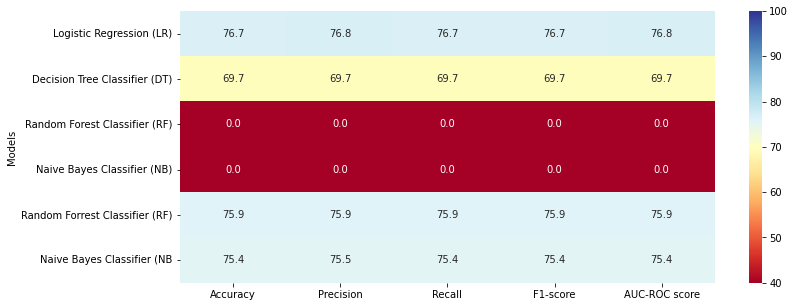

In [54]:
# Camparing all the models score

plt.figure(figsize=[12,5])
sns.heatmap(result_df, annot=True, vmin=40, vmax=100.0, cmap='RdYlBu', fmt='.1f')
plt.show()

In evaluating there are a  few  metrics we can use to measure performance:

* **Accuracy:** The ratio of he number of correct predictions and te al number of predictions.
* **Precision:** The number of ue positives over the number of predicted positives.
* **Recall:** The number of true positives over the total number of actual positives.
* **F1-Score:** The harmonic mean of precision and recall.

Since F1-Score is the combined idea between **Precision** and **Recall** then I will focus on the F1-Score of the Random Forest classifier since it performs best on the current dataset.  Performance can be incresed using hyperparametr tuning.  Let's try some random values for some of the parameters.

In [55]:
param_grid = {
    'n_estimators': [100,200,3000,400],
    'max_features': ['sqrt','log2'],
    'max_depth': [1,2,4,5,6,7,8],
    'criterion': ['gini','entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv=5,n_jobs=-1)
CV_rfc.fit(X_train,y_train)

In [ ]:
CV_fc.best_params_

In [ ]:
RF_model_cv=RandomForestClassifier(random_state=42,**CV_rfc.best_params_)
RF_model_cv.fit(X_train,y_train)

In [ ]:
conf_mat_plot([RF_model_cv])

In [ ]:
pred = RF_model_cv.predict(X_test)
pred_prob = RF_model_cv.predict_proba(X_test)
print(classification_report(pred,pred_prob))
accuracy_score(y_test,y_pred)
print(round(roc_auc_score(y_test,pred_prob,multi_class='ovr'),3)*100)
auc_roc(y_test,pred_prob)